### Phone Recommendation system


In [1]:
import os

In [2]:
%pwd

'd:\\Imarticus_Learning\\12_Projects\\Phone_Recommendation_System\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\Imarticus_Learning\\12_Projects\\Phone_Recommendation_System'

In [5]:
from dataclasses import dataclass
from pathlib import Path


@dataclass
class DataTransformConfig:
    root_dir: Path
    extracted_data_file: Path
    transform_data_file: Path
    vectorizer_file: Path

In [6]:
from phone_recommender.constants import *
from phone_recommender.utils.common import read_yaml, create_directories

In [7]:
class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH) -> None:
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

    def get_data_transform_config(self) -> DataTransformConfig:
        config = self.config.data_transform

        create_directories([config.root_dir])

        data_transform_config = DataTransformConfig(
            root_dir=config.root_dir,
            extracted_data_file=config.extracted_data_file,
            transform_data_file=config.transform_data_file,
            vectorizer_file=config.vectorizer_file,
        )

        return data_transform_config

In [8]:
import re
import string
import pickle


# Data handling libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Libraries


from phone_recommender.logging import logger
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# to ignore warnings
import warnings

warnings.filterwarnings('ignore')

In [9]:
class DataTransform:
    def __init__(self, config: DataTransformConfig) -> None:
        self.config = config

        create_directories([self.config.root_dir])

    def get_extracted_data(self):
        extracted_data_file = self.config.extracted_data_file
        if not os.path.exists(extracted_data_file):
            logger.info("No extracted data file exists please check if data extraction is complete!")
        else:
            df = pd.read_csv(extracted_data_file)
            return df

    def save_transformed_data(self, df: pd.DataFrame):
        df.to_csv(self.config.transform_data_file, index=False)

    def get_transform_dataframe(df_cate: pd.DataFrame):
        trans_columns = [
            'brand',
            'network',
            'released_year',
            'resolution',
            'display_size_str',
            'display_type',
            'os',
            'chipset',
            'ram',
            'storage',
            'type',
            'main_camera',
            'selfie_camera',
            'bluetooth',
            'battery',
        ]
        df_trans = df_cate[trans_columns]

        return df_trans

    def transform_dataframe(self, df_cate, df_trans):
        df_trans['text'] = df_trans.apply(lambda row: " ".join(map(str, row)), axis=1)
        df_cate['text'] = df_trans.apply(lambda row: " ".join(map(str, row)), axis=1)
        df_trans['text'] = df_trans['text'].apply(lambda x: " ".join(x.split()))
        df_trans['text'] = df_trans['text'].apply(
            lambda x: "".join([char for char in x if char not in string.punctuation])
        )

        return df_trans, df_cate

    def save_vectorizer(self, vectorizer):
        with open(self.config.vectorizer_file, "wb") as handle:
            pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Getting Extracted Data


In [10]:
try:
    config = ConfigurationManager()
    data_transform_config = config.get_data_transform_config()
    data_transform = DataTransform(data_transform_config)
    df = data_transform.get_extracted_data()
    df['display_size_str'] = df['display_size_str'].astype('str')
    df_cate = df[df.select_dtypes(include='object').columns]
    df_trans = data_transform.get_transform_dataframe(df_cate)
    df_trans, df_cate = data_transform.transform_dataframe(df_cate=df_cate, df_trans=df_trans)
    cv = CountVectorizer()
    df_cv = cv.fit_transform(df_trans['text'])
    df_dtm = pd.DataFrame.sparse.from_spmatrix(df_cv, columns=cv.get_feature_names_out())
    tdm = df_dtm.T
    tdm['freq'] = tdm.sum(axis=1)
    tdm.reset_index(inplace=True)
    tdm.rename(columns={'index': 'words'}, inplace=True)
    tdm1 = tdm[['words', 'freq']]
    tdm1 = tdm1.sort_values('freq', ascending=False)
    tdm1.reset_index(inplace=True)
    tdm1.drop("index", inplace=True, axis=1)

    ssd = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(df_dtm)
        scr = kmeans.score(df_dtm)
        ssd.append(scr)
        print(f"cluster number {i} cluster remaining {10 - i}")

    clusters = KMeans(n_clusters=3, random_state=42).fit_predict(df_dtm)

    idf = TfidfVectorizer()
    df_tfidf = idf.fit_transform(df_trans['text'])
    tfidf = pd.DataFrame.sparse.from_spmatrix(df_tfidf, columns=idf.get_feature_names_out())

    ssd = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(tfidf)
        scr = kmeans.score(tfidf)
        ssd.append(scr)
        print(f"cluster number {i} cluster remaining {10 - i}")

    cluster2 = KMeans(n_clusters=3, random_state=42).fit_predict(tfidf)

    data_transform.save_vectorizer(cv)

    df_trans['class'] = clusters
    df_cate['class'] = clusters
    data_transform.save_transformed_data(df_cate)
except Exception as e:
    raise e

[2023-12-08 00:24:05,435: INFO: common: yaml file: config\config.yaml loads successfully]
[2023-12-08 00:24:05,442: INFO: common: yaml file: params.yaml loads successfully]
[2023-12-08 00:24:05,444: INFO: common: created directory at : artifacts/data_transform]
[2023-12-08 00:24:05,445: INFO: common: created directory at : artifacts/data_transform]


### Data Transformation


In [11]:
df.head()

,brand,phone_name,text,network,4g_bands,4g_band_count,5g_bands,5g_band_count,released_year,height_width_depth,...,display_type,os,chipset,ram,storage,type,main_camera,selfie_camera,bluetooth,battery
0,huawei,nova 11 SE,network technology gsm / cdma / hspa / cdma200...,lte,1 3 4 5 8 18 19 26 34 38 39 40,12,0,0,2023,162.4 75.5 7.4,...,oled 90hz,harmony4.0,snapdragon680,0,0,0,108mp,32mp,bluetooth5.0,4500mah
1,huawei,Mate 60 Pro+,network technology gsm / cdma / hspa / cdma200...,lte 5g,1,1,1,1,2023,163.7 79 8.1,...,ltpo oled 120hz,harmony4.0,kirin9000s,16gb,1tb 512gb,ufs,48mp,13mp,bluetooth5.2,5000mah
2,huawei,Mate X5,network technology gsm / cdma / hspa / evdo / ...,lte 5g,1,1,1,1,2023,156.9 141.5 5.3,...,oled 120hz,harmony4.0,kirin9000s,12gb 16gb,1tb 256gb 512gb,ufs,50mp,8mp,bluetooth5.2,5060mah
3,huawei,Mate 60 Pro,network technology gsm / cdma / hspa / cdma200...,lte 5g,1,1,1,1,2023,163.7 79 8.1,...,ltpo oled 120hz,harmony4.0,kirin9000s,12gb,1tb 256gb 512gb,ufs,50mp,13mp,bluetooth5.2,5000mah
4,huawei,nova Y91,network technology gsm / hspa / lte 2g bands g...,lte,1 2 3 4 5 7 8 13 20 26 28 38 40 41,14,0,0,2023,171.6 79.9 8.9,...,ips lcd 90hz,emui13,snapdragon680,6gb 8gb,128gb 256gb,0,50mp,8mp,bluetooth5.0,7000mah


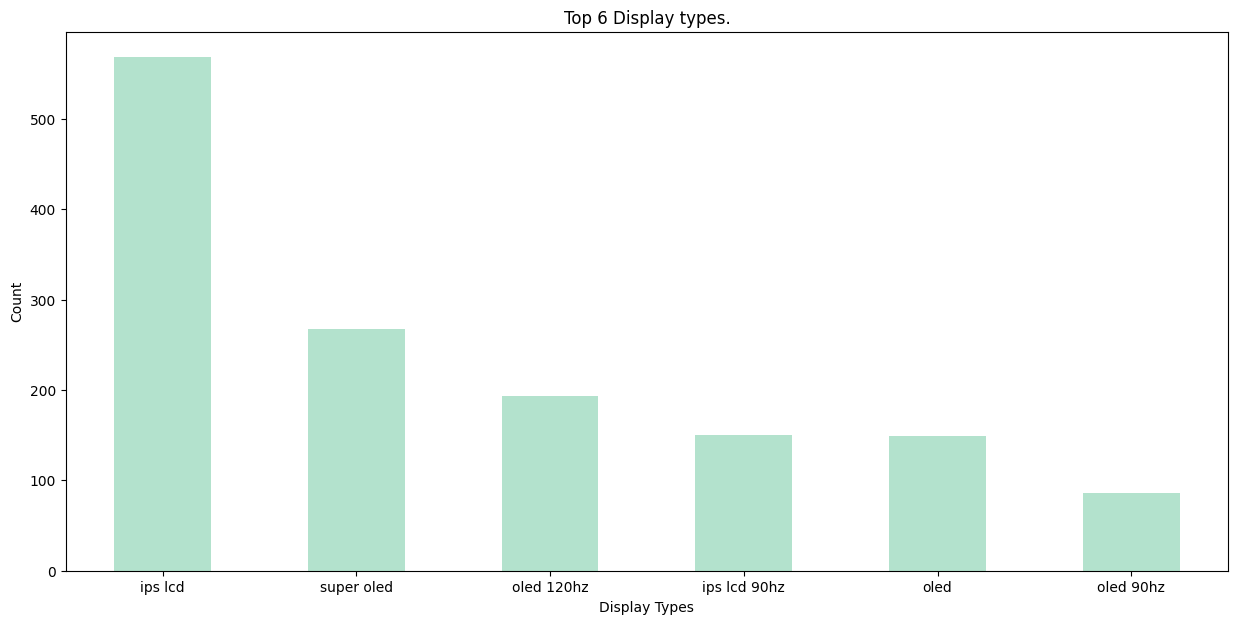

In [16]:
plt.figure(figsize=(15, 7))
df['display_type'].value_counts().head(6).plot(
    kind='bar',
    colormap='Pastel2',
    rot=360,
    xlabel="Display Types",
    title="Top 6 Display types.",
    ylabel="Count",
    fontsize=10,
)

plt.show()

- Analysis:
  - Most common type of display used in mobile phone is ips panel.
  - Followed by super oled which is better than ips in terms of brightness and color contrast.


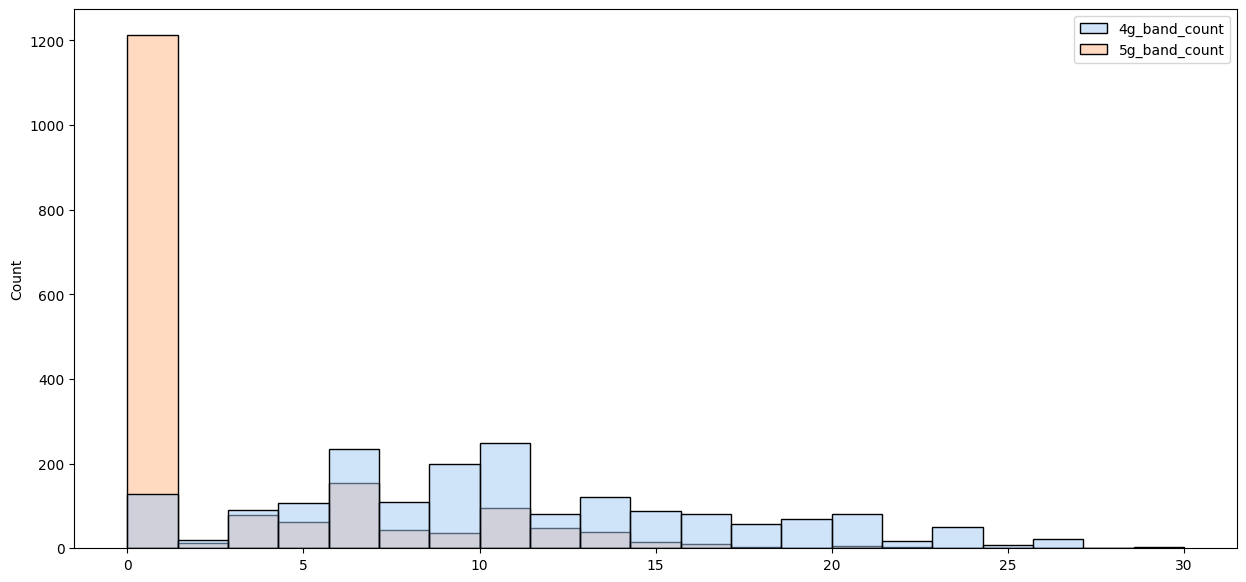

In [17]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df[['4g_band_count', '5g_band_count']], palette='pastel')
plt.show()

- Analysis
  - A lot of phones don't have 5g bands in our data set.
  - And also most of the phones have bands in between 5 to 15 may the phone be 5g or 4g.


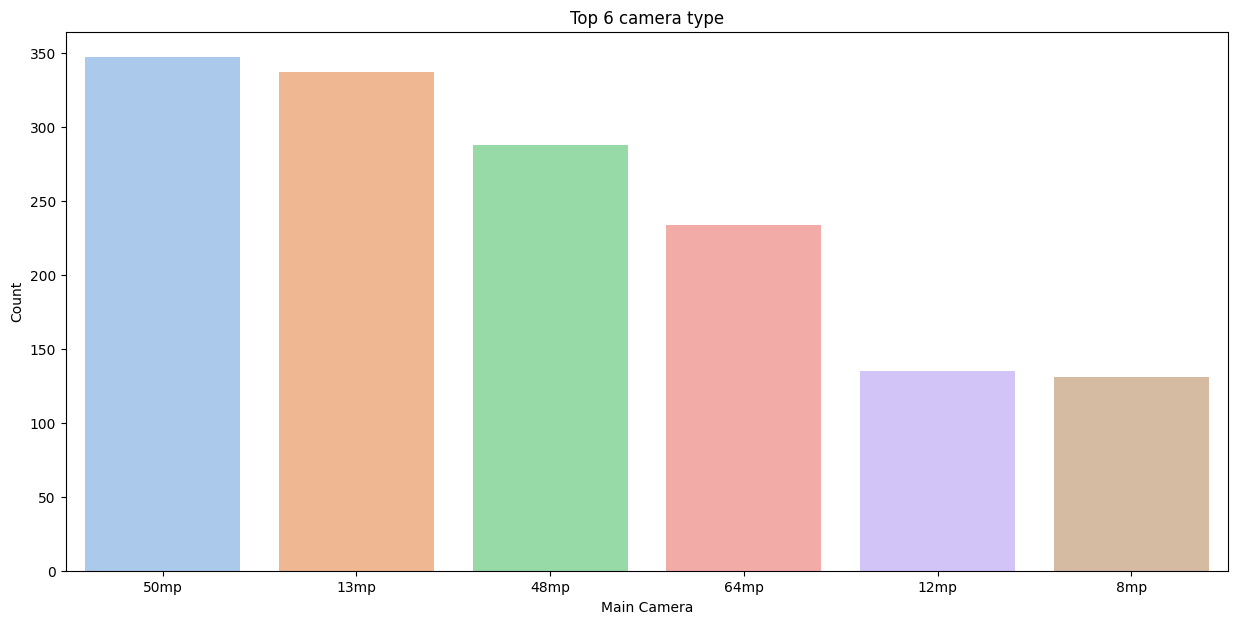

In [18]:
plt.figure(figsize=(15, 7))
sns.barplot(df['main_camera'].value_counts().head(6), palette='pastel')
plt.title("Top 6 camera type")
plt.xlabel("Main Camera")
plt.ylabel("Count")
plt.show()

- Analysis:
  - So 50mp, 13mp followed by 48mp can be seen in a lot of phones with respect to data.
  - Note: the camera mega pixel don't matter a lot when it comes to the picture quality but also the camera app which plays the most important role in making the image as these cameras heavily relies on the AI to process the image.


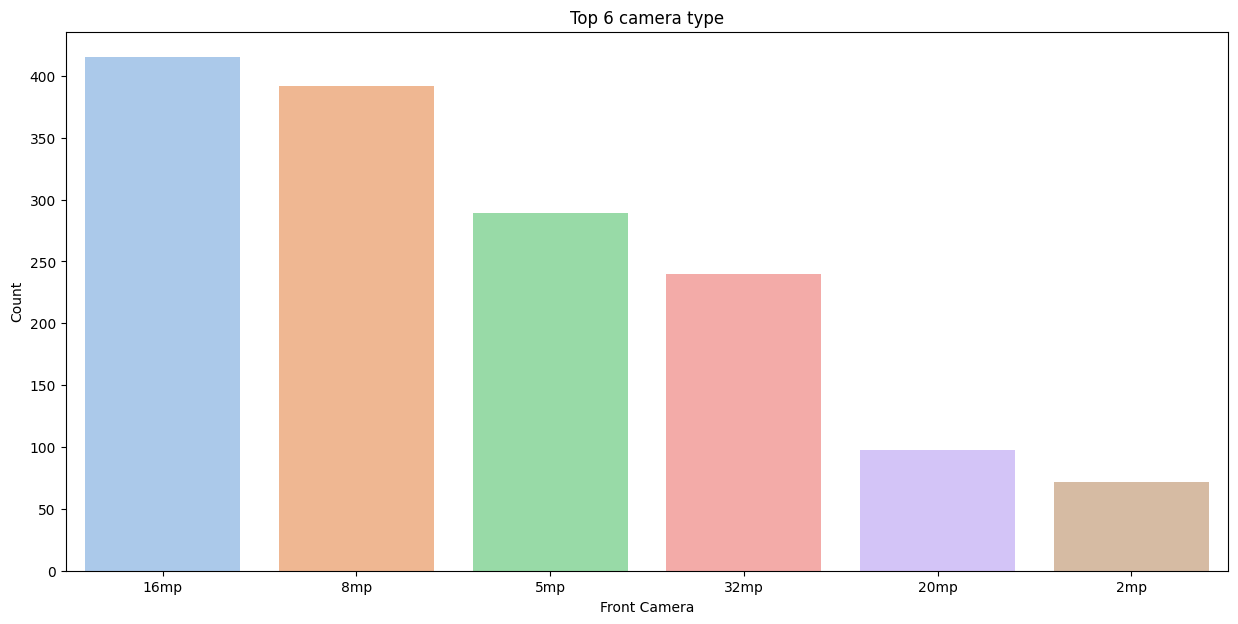

In [19]:
plt.figure(figsize=(15, 7))
sns.barplot(df['selfie_camera'].value_counts().head(6), palette='pastel')
plt.title("Top 6 camera type")
plt.xlabel("Front Camera")
plt.ylabel("Count")
plt.show()

- Analysis:
  - In terms of front camera the 16mp and 8mp is the most common choice.


[2023-12-08 00:00:25,438: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2023-12-08 00:00:25,444: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]


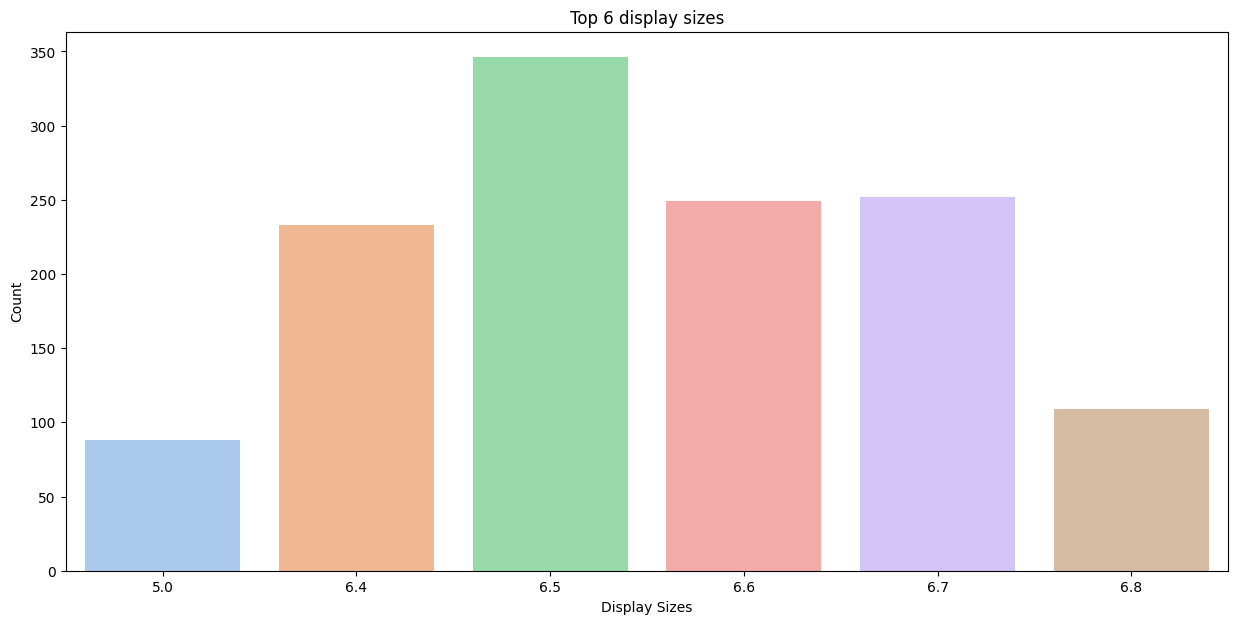

In [20]:
plt.figure(figsize=(15, 7))
sns.barplot(df['display_size'].value_counts().head(6), palette='pastel')
plt.title("Top 6 display sizes")
plt.xlabel("Display Sizes")
plt.ylabel("Count")
plt.show()

- Analysis:
  - So as we can see as of now the most common display size is 6.5 inch followed by 6.7 and 6.6.
  - The pattern here that we can see is the now brands are moving towards bigger displays from smaller once.


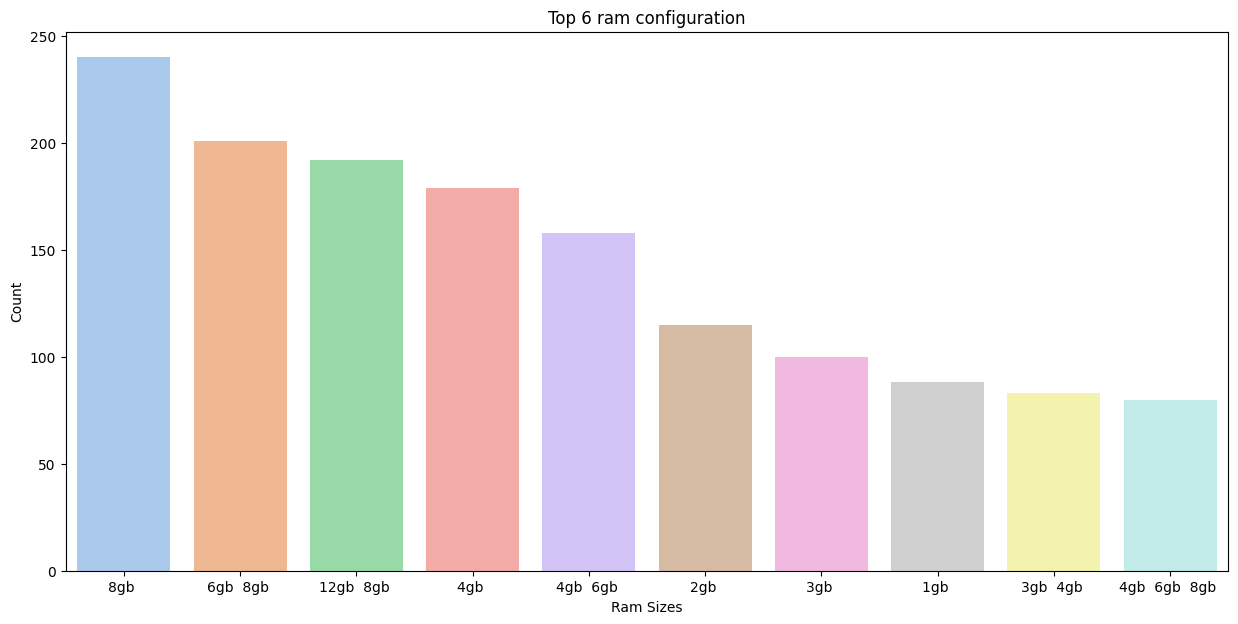

In [11]:
plt.figure(figsize=(15, 7))
sns.barplot(df['ram'].value_counts().head(10), palette='pastel')
plt.title("Top 6 ram configuration")
plt.xlabel("Ram Sizes")
plt.ylabel("Count")
plt.show()

- Analysis:
  - So as we can see that a lot of phones offer ram from 6gb to 12gb.
  - With 8gb being the most common option.


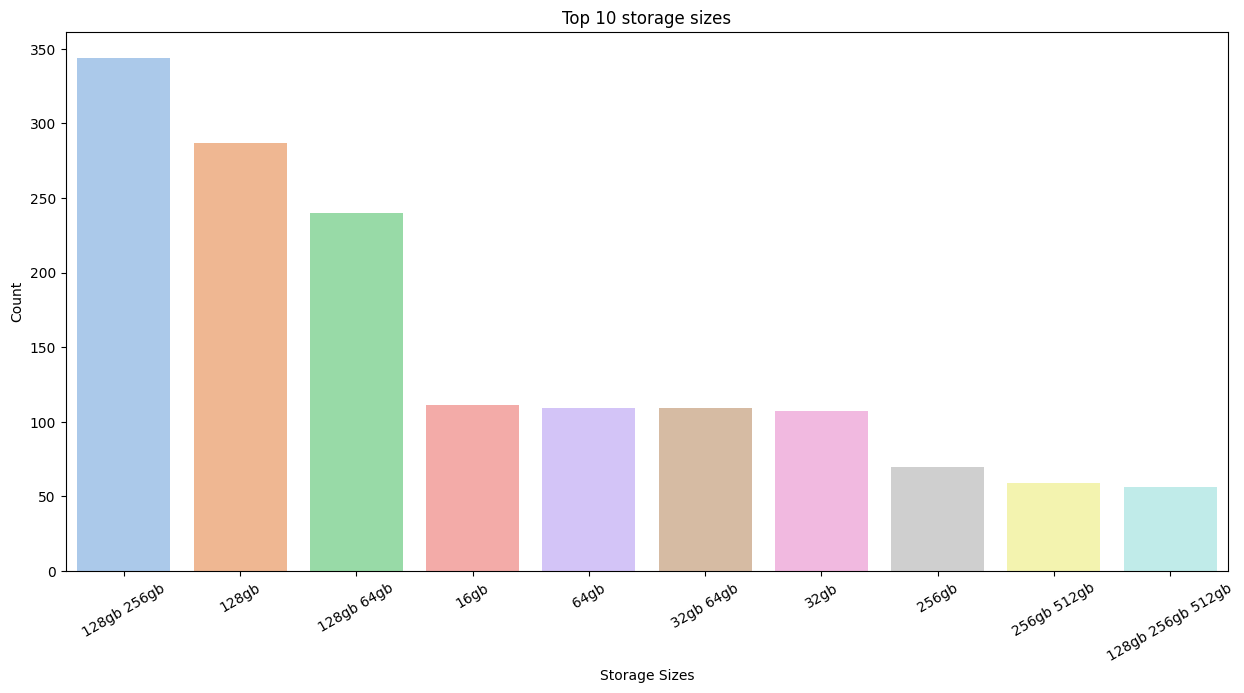

In [22]:
plt.figure(figsize=(15, 7))
sns.barplot(df['storage'].value_counts().head(10), palette='pastel')
plt.xticks(rotation=30)
plt.title("Top 10 storage configuration")
plt.xlabel("Storage Sizes")
plt.ylabel("Count")
plt.show()

- Analysis:
  - In todays world of growing file sizes we can see that 128 gb and 256gb config are the most common.


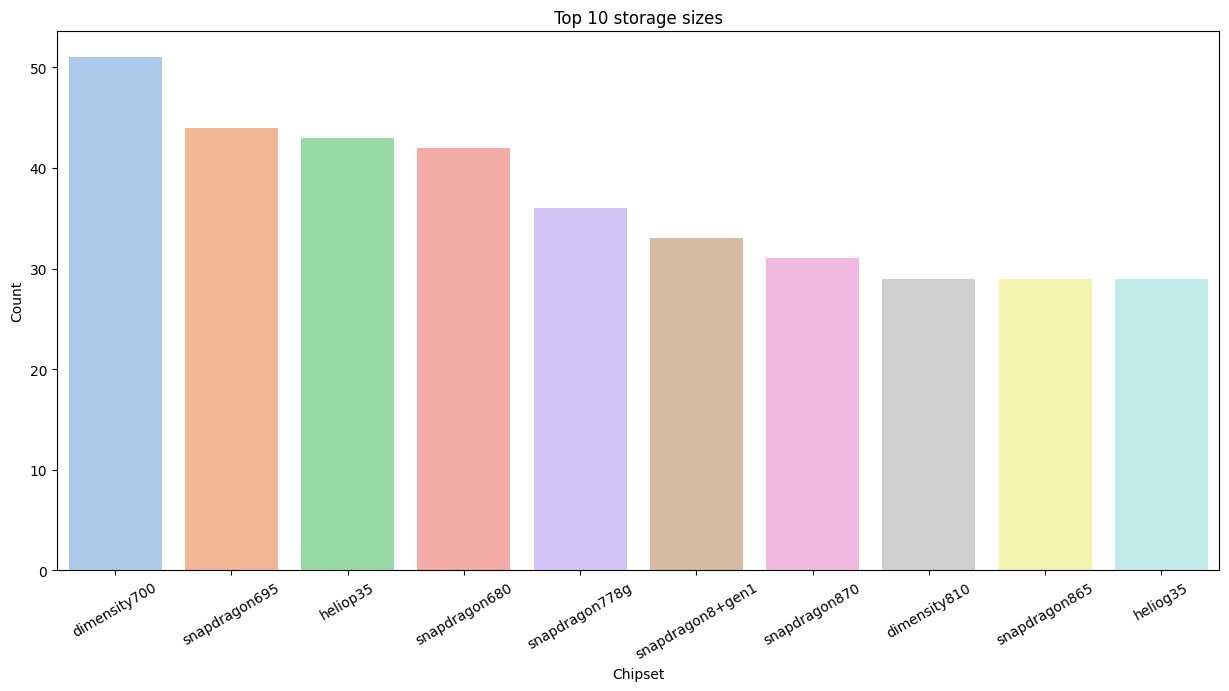

In [23]:
plt.figure(figsize=(15, 7))
sns.barplot(df['chipset'].value_counts()[1:].head(10), palette='pastel')
plt.xticks(rotation=30)
plt.title("Top 10 chipset used in phones")
plt.xlabel("Chipset")
plt.ylabel("Count")
plt.show()

- Analysis:
  - Top 10 chipset used by phone manufactures.


#### Data Transform


In [24]:
df_cate.columns

Index(['brand', 'phone_name', 'text', 'network', '4g_bands', '5g_bands',
       'released_year', 'height_width_depth', 'resolution', 'display_size_str',
       'display_type', 'os', 'chipset', 'ram', 'storage', 'type',
       'main_camera', 'selfie_camera', 'bluetooth', 'battery'],
      dtype='object')

In [25]:
df_cate.shape

(1819, 20)

In [27]:
df_trans.shape

(1819, 15)

In [29]:
df_trans['text'][0]

'huawei lte 2023 1080 2400 6.7 oled 90hz harmony4.0 snapdragon680 0 0 0 108mp 32mp bluetooth5.0 4500mah'

In [35]:
tdm.shape

(648, 1819)

In [37]:
tdm1.head(20)

,words,freq
0,lte,1819
1,1080,1041
2,128gb,1025
3,lcd,918
4,8gb,868
5,oled,842
6,ips,817
7,5g,652
8,256gb,604
9,5000mah,600


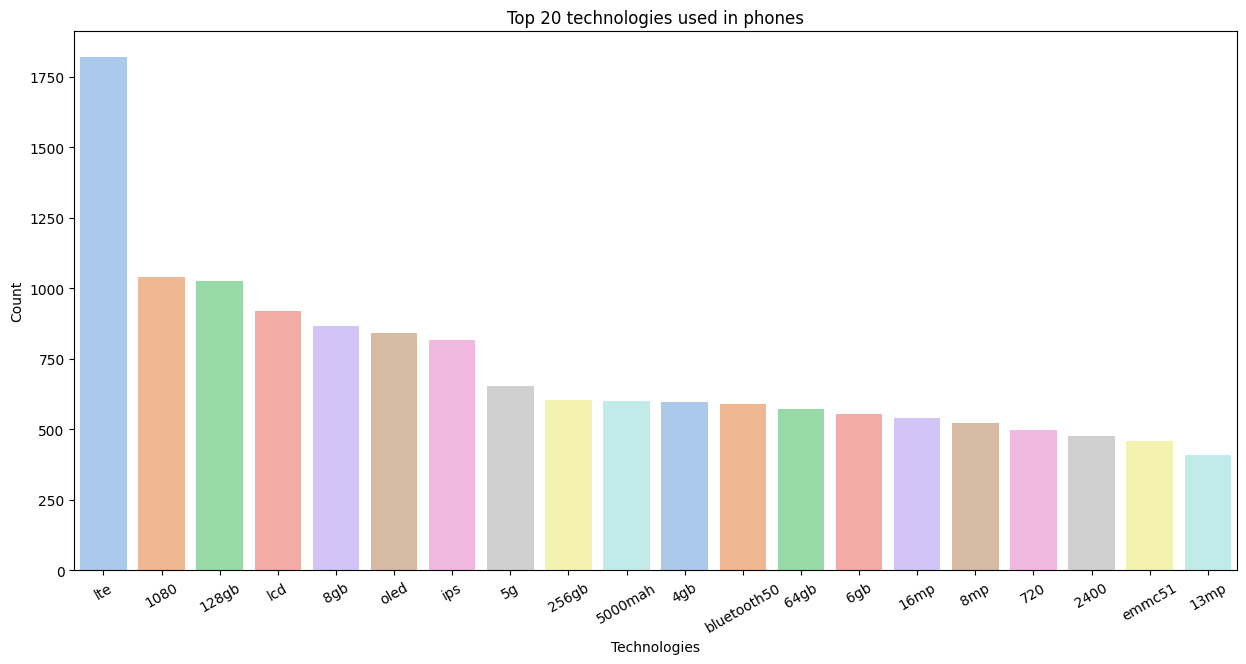

In [38]:
plt.figure(figsize=(15, 7))
sns.barplot(x=tdm1['words'].head(20), y=tdm1['freq'].head(20), palette='pastel')
plt.title("Top 20 technologies used in phones")
plt.xlabel("Technologies")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

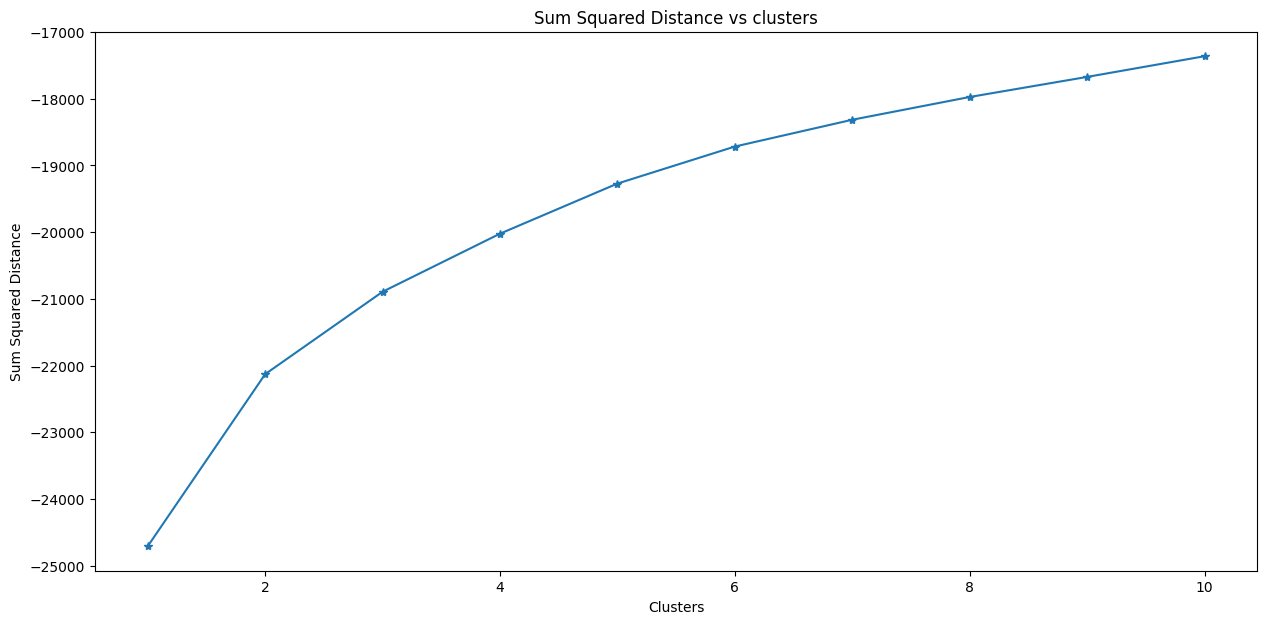

In [40]:
plt.figure(figsize=(15, 7))
plt.plot(range(1, 11), ssd, "-*")
plt.title("Sum Squared Distance vs clusters")
plt.xlabel("Clusters")
plt.ylabel("Sum Squared Distance")
plt.show()

In [41]:
ssd = np.array(ssd)
(ssd[:-1] - ssd[1:]) * 100 / ssd[:-1]

array([10.43589344,  5.58069779,  4.16571984,  3.75033275,  2.87849834,
        2.14569619,  1.86156611,  1.67421154,  1.75396796])

In [43]:
sil_val = silhouette_samples(df_dtm, clusters)
sil_df = pd.DataFrame()
sil_df['cluster'] = clusters
sil_df['score'] = sil_val

In [44]:
error = sil_df[sil_df['score'] < 0]
len(error)

46

In [45]:
np.sqrt(np.mean(np.square(0 - error['score'])))

0.00852975045330614

In [46]:
tfidf.head()

,00,100mp,101,1080,1084,108mp,10gb,10mp,1176,1200,...,ufs22,ufs3,ufs30,ufs31,ufs31nvmessd,ufs40,umcp,vivo,xiaomi,еmmc
0,0.0,0.0,0.0,0.123032,0.0,0.316469,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.098514,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


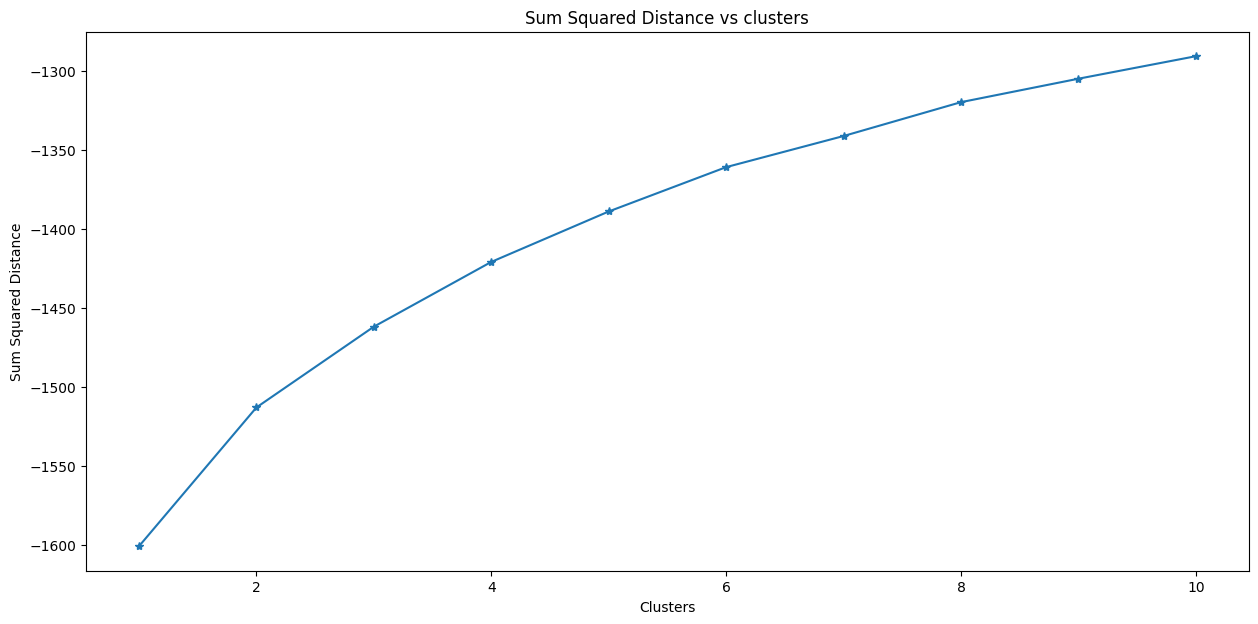

In [48]:
plt.figure(figsize=(15, 7))
plt.plot(range(1, 11), ssd, "-*")
plt.title("Sum Squared Distance vs clusters")
plt.xlabel("Clusters")
plt.ylabel("Sum Squared Distance")
plt.show()

In [49]:
ssd = np.array(ssd)
(ssd[:-1] - ssd[1:]) * 100 / ssd[:-1]

array([5.48835615, 3.38081025, 2.80545227, 2.24746693, 2.02171195,
       1.44814131, 1.59854309, 1.12502734, 1.0919985 ])

In [51]:
sil_val = silhouette_samples(tfidf, clusters)
sil_df = pd.DataFrame()
sil_df['cluster'] = clusters
sil_df['score'] = sil_val

In [52]:
error = sil_df[sil_df['score'] < 0]
len(error)

82

In [53]:
np.sqrt(np.mean(np.square(0 - error['score'])))

0.010079961540787918

- Count Vectorizer is working good for clustering our data as compared to tfidf.
- Also count using count vectorizer kmeans is miss placing 46 records as compared to 82 in tfidf.


### Cluster Analysis


In [56]:
dfc1 = df_trans[df_trans['class'] == 0]
dfc2 = df_trans[df_trans['class'] == 1]
dfc3 = df_trans[df_trans['class'] == 2]

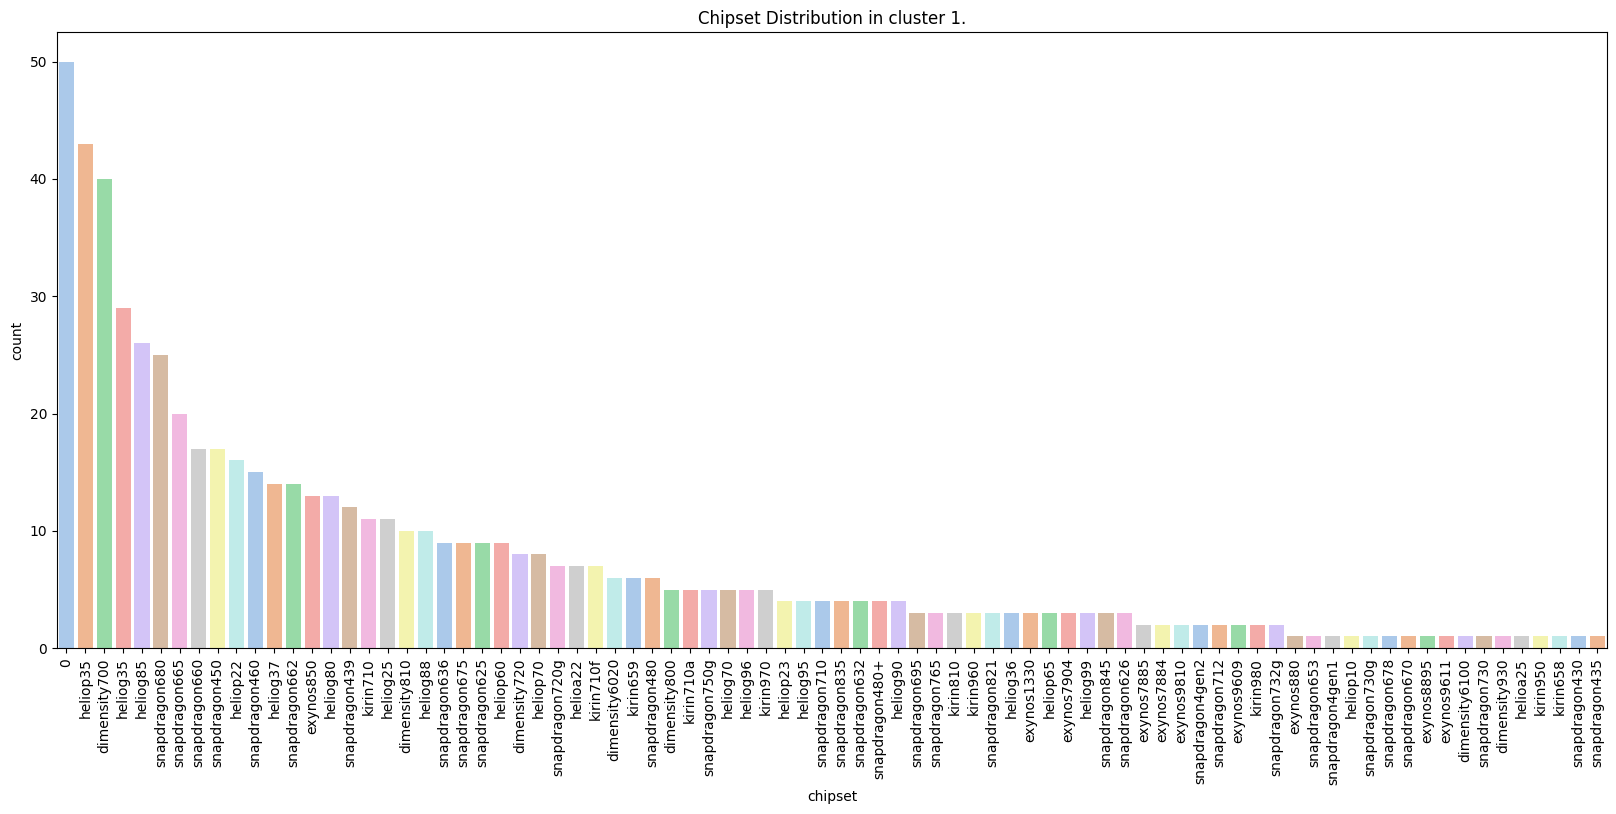

In [57]:
plt.figure(figsize=(20, 8))
sns.barplot(data=dfc1['chipset'].value_counts(), palette='pastel')
plt.title("Chipset Distribution in cluster 1.")
plt.xticks(rotation=90)
plt.show()

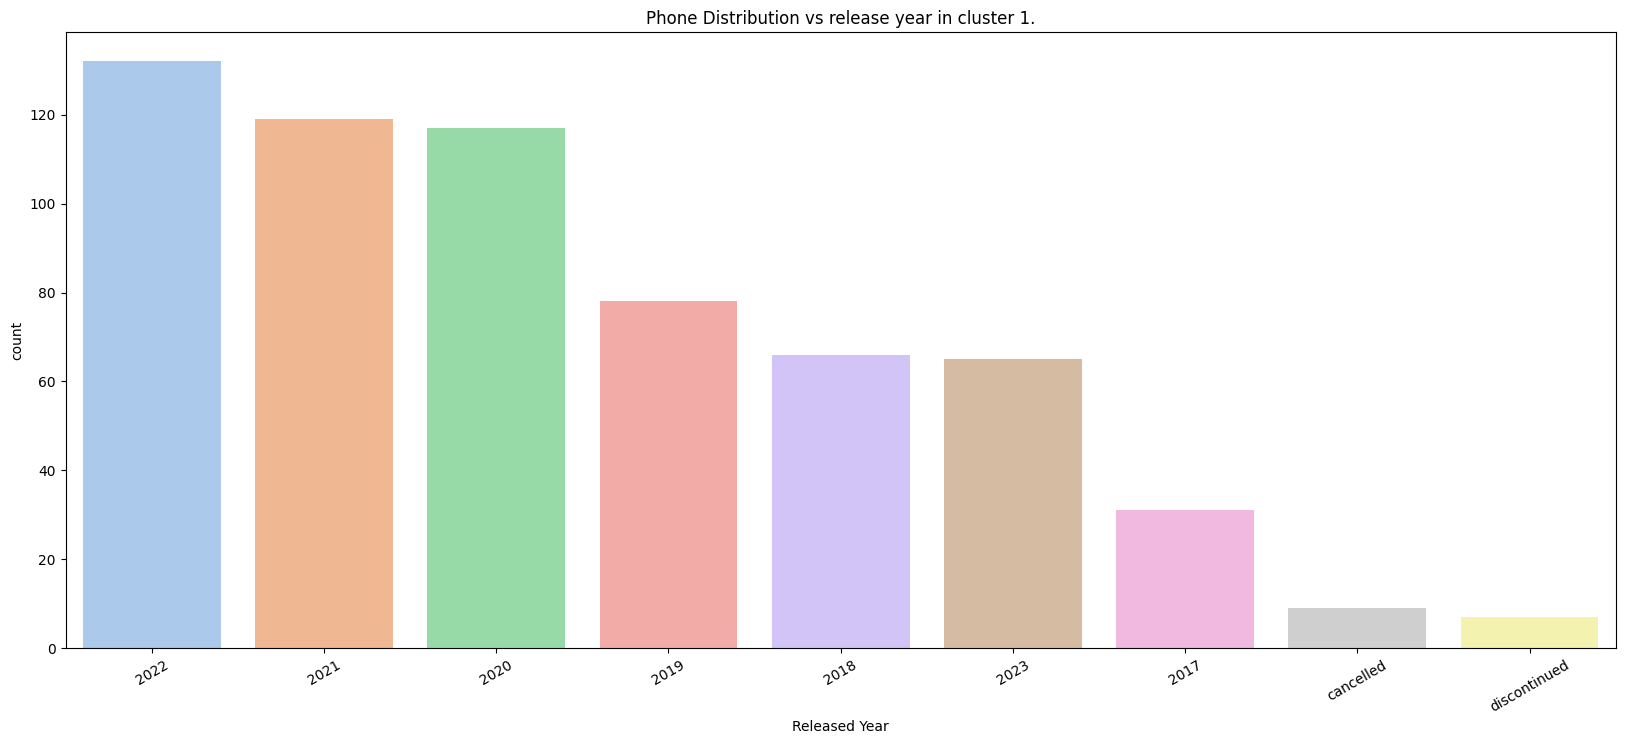

In [58]:
plt.figure(figsize=(20, 8))
sns.barplot(dfc1['released_year'].value_counts(), palette='pastel')
plt.title("Phone Distribution vs release year in cluster 1.")
plt.xticks(rotation=30)
plt.xlabel("Released Year")
plt.show()

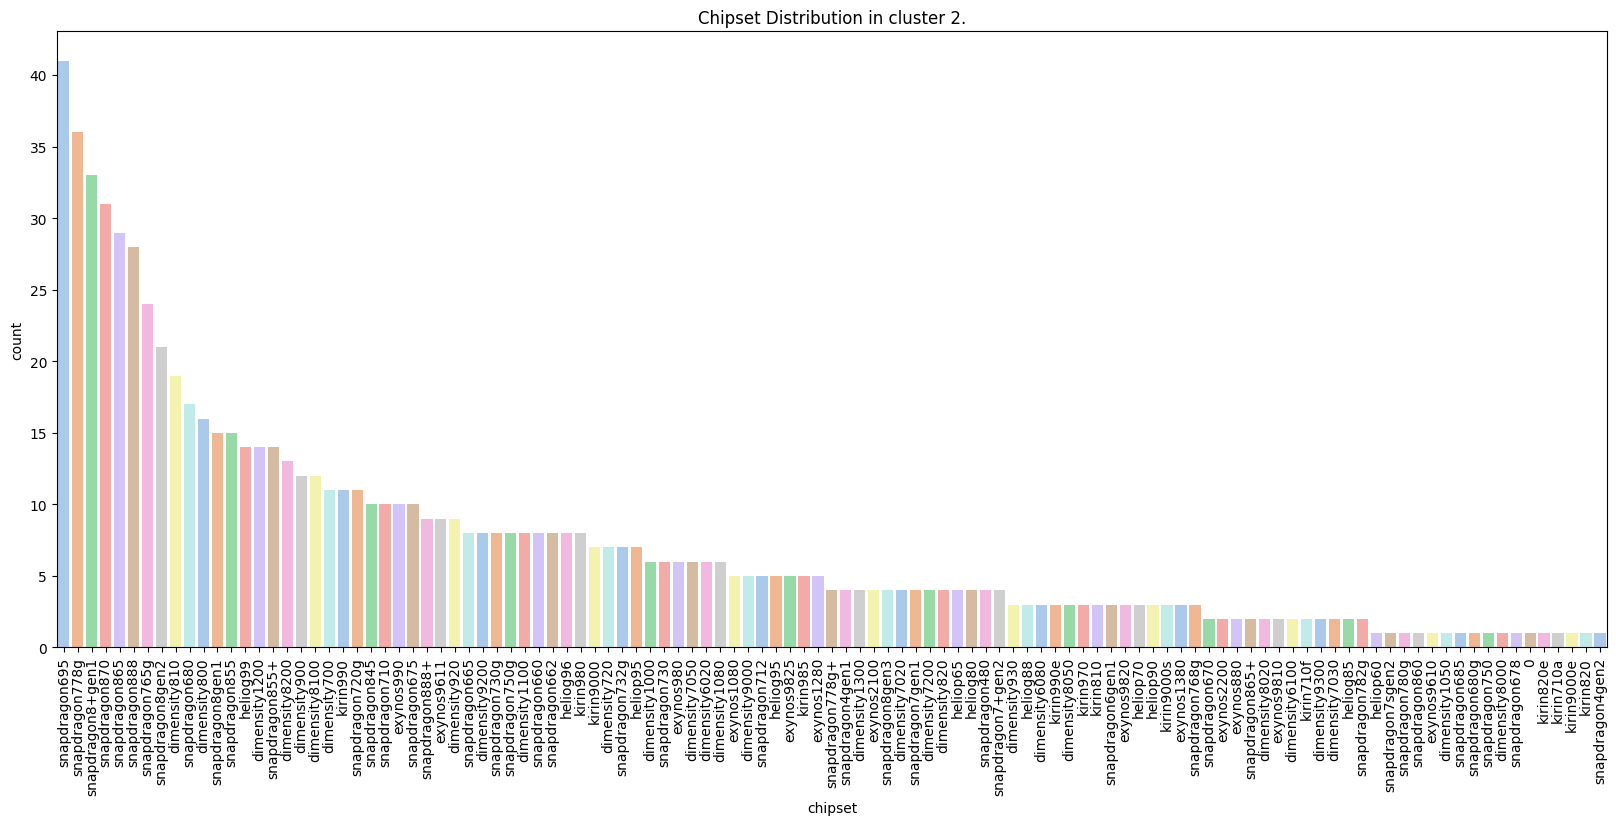

In [59]:
plt.figure(figsize=(20, 8))
sns.barplot(data=dfc2['chipset'].value_counts(), palette='pastel')
plt.title("Chipset Distribution in cluster 2.")
plt.xticks(rotation=90)
plt.show()

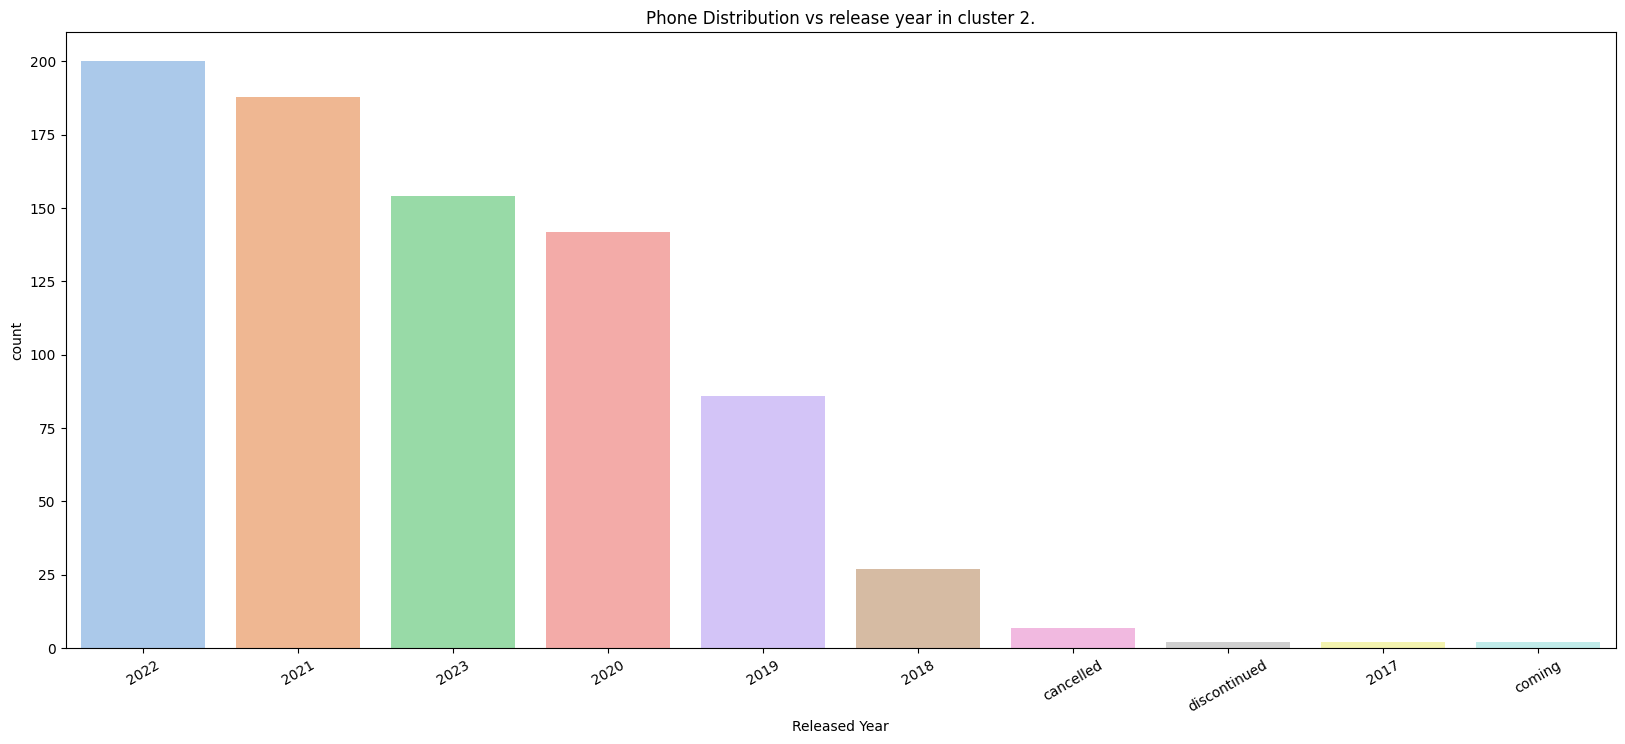

In [60]:
plt.figure(figsize=(20, 8))
sns.barplot(dfc2['released_year'].value_counts(), palette='pastel')
plt.title("Phone Distribution vs release year in cluster 2.")
plt.xticks(rotation=30)
plt.xlabel("Released Year")
plt.show()

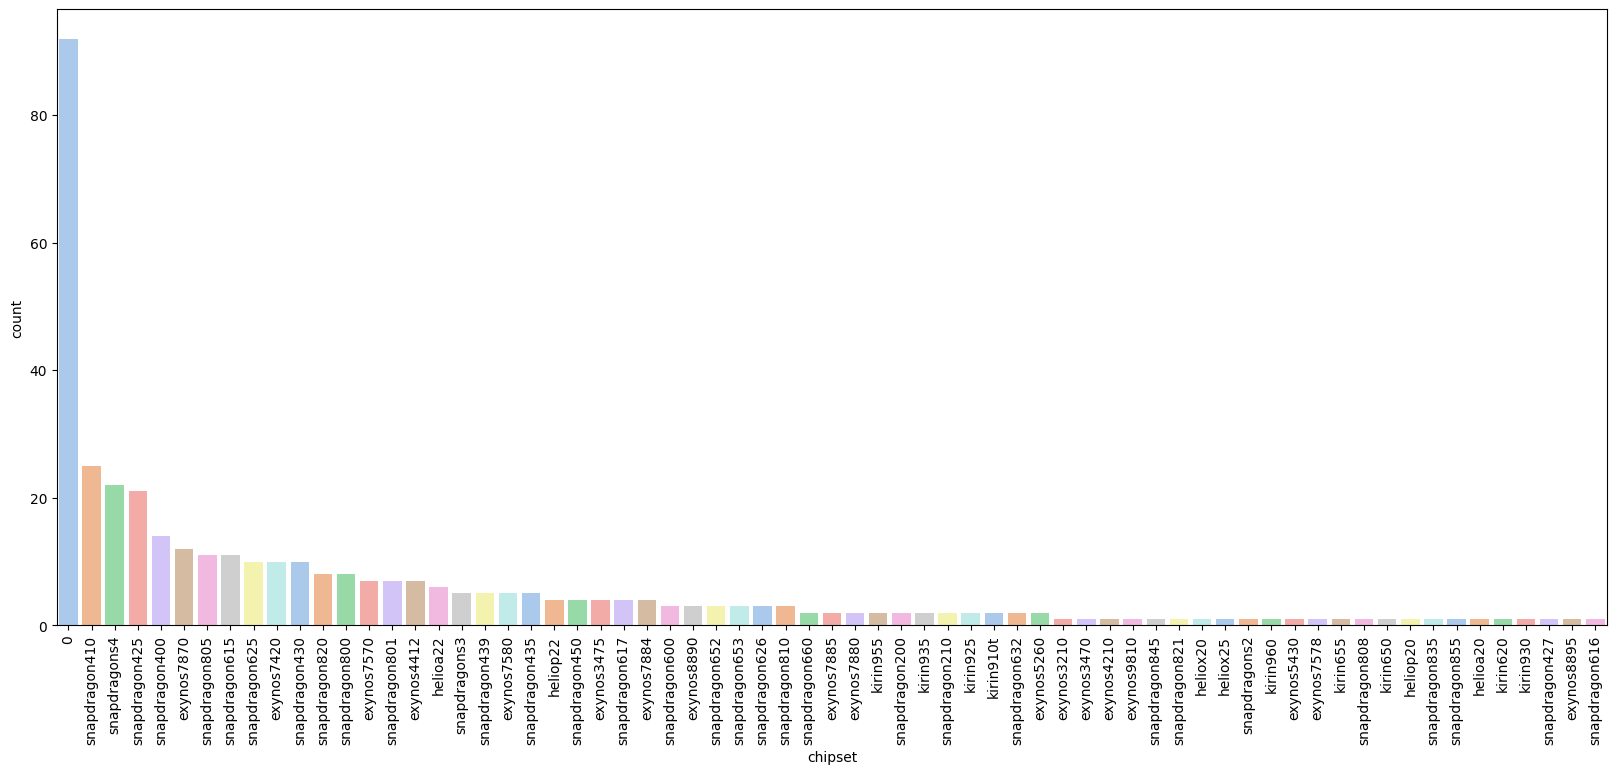

In [61]:
plt.figure(figsize=(20, 8))
sns.barplot(data=dfc3['chipset'].value_counts(), palette="pastel")
plt.title("Chipset Distribution in cluster 3.")
plt.xticks(rotation=90)
plt.show()

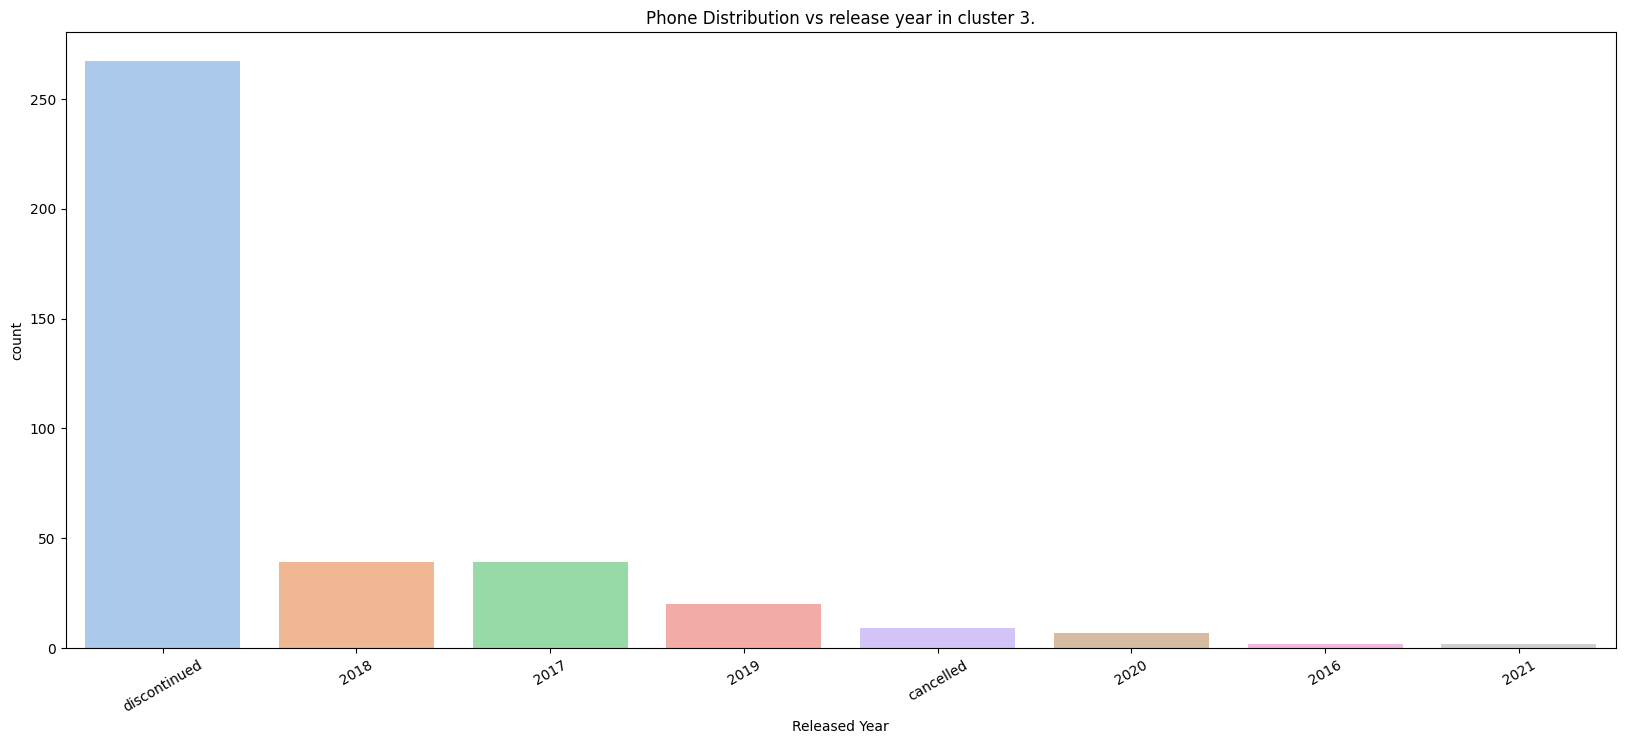

In [62]:
plt.figure(figsize=(20, 8))
sns.barplot(dfc3['released_year'].value_counts(), palette='pastel')
plt.title("Phone Distribution vs release year in cluster 3.")
plt.xticks(rotation=30)
plt.xlabel("Released Year")
plt.show()

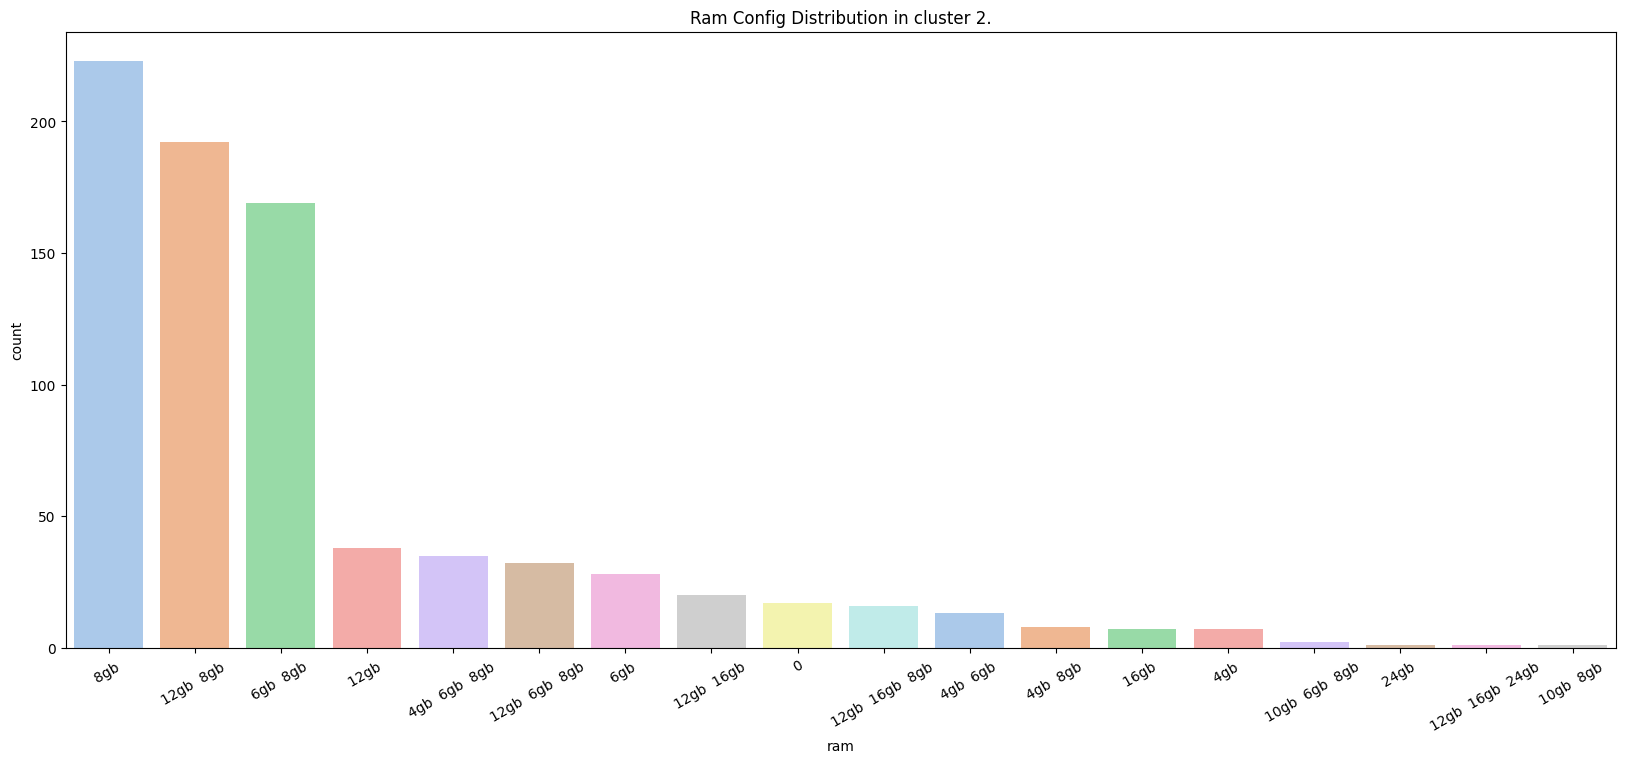

In [64]:
plt.figure(figsize=(20, 8))
sns.barplot(dfc2['ram'].value_counts(), palette='pastel')
plt.title("Ram Config Distribution in cluster 2.")
plt.xticks(rotation=30)
plt.show()

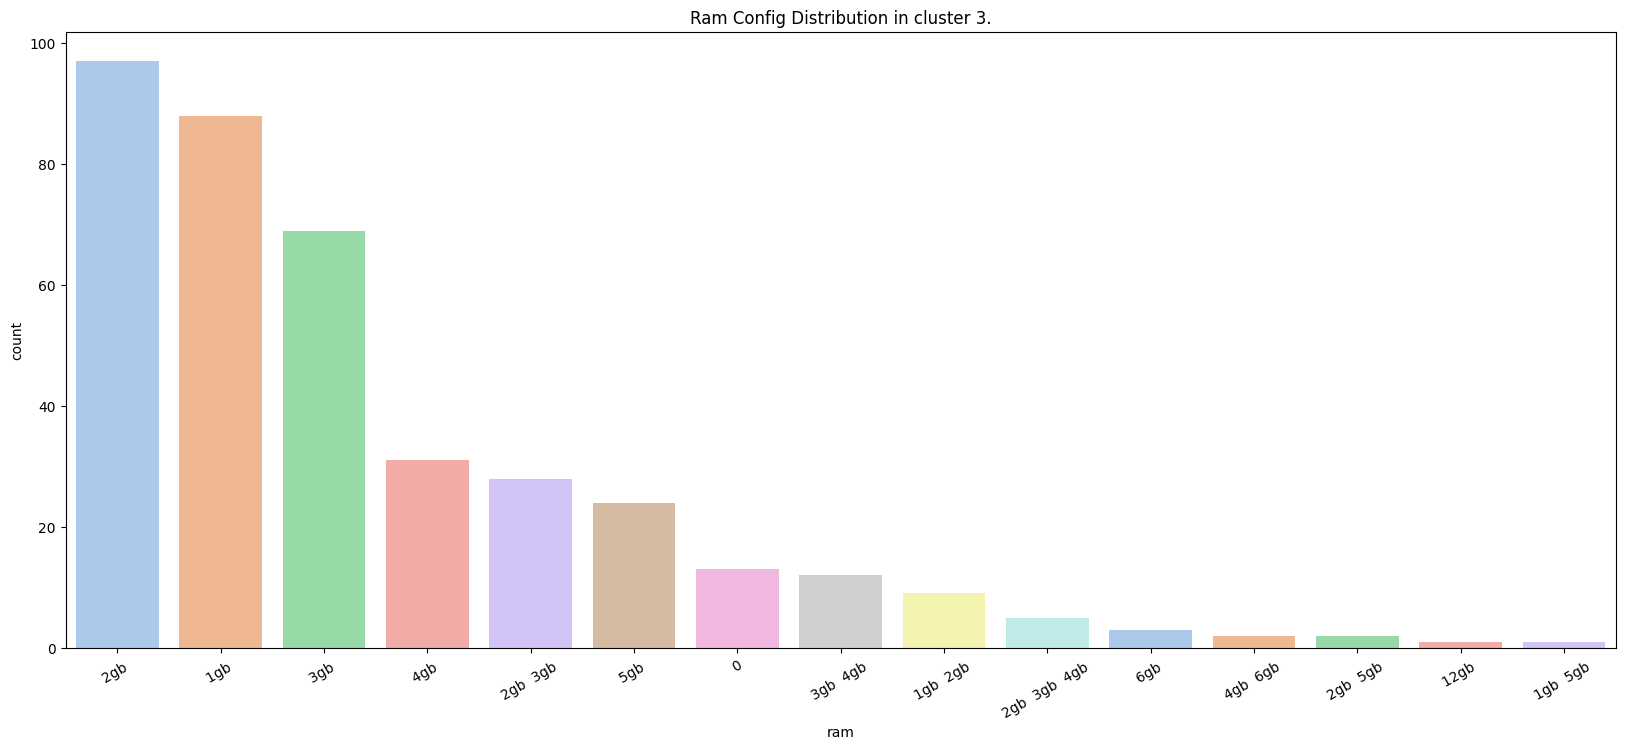

In [65]:
plt.figure(figsize=(20, 8))
sns.barplot(dfc3['ram'].value_counts(), palette='pastel')
plt.title("Ram Config Distribution in cluster 3.")
plt.xticks(rotation=30)
plt.show()

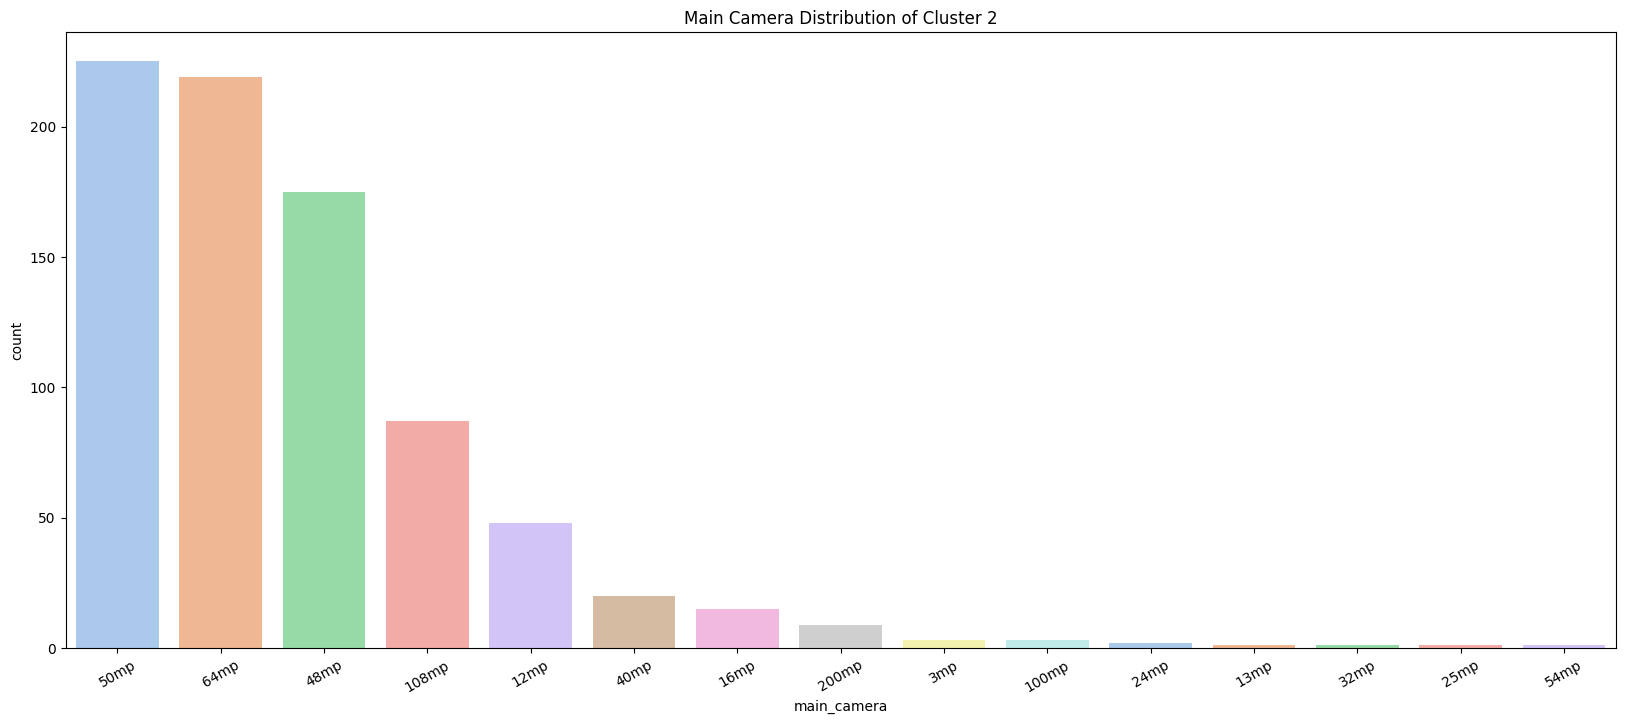

In [66]:
plt.figure(figsize=(20, 8))
sns.barplot(dfc2['main_camera'].value_counts(), palette='pastel')
plt.title("Main Camera Distribution of Cluster 2")
plt.xticks(rotation=30)
plt.show()

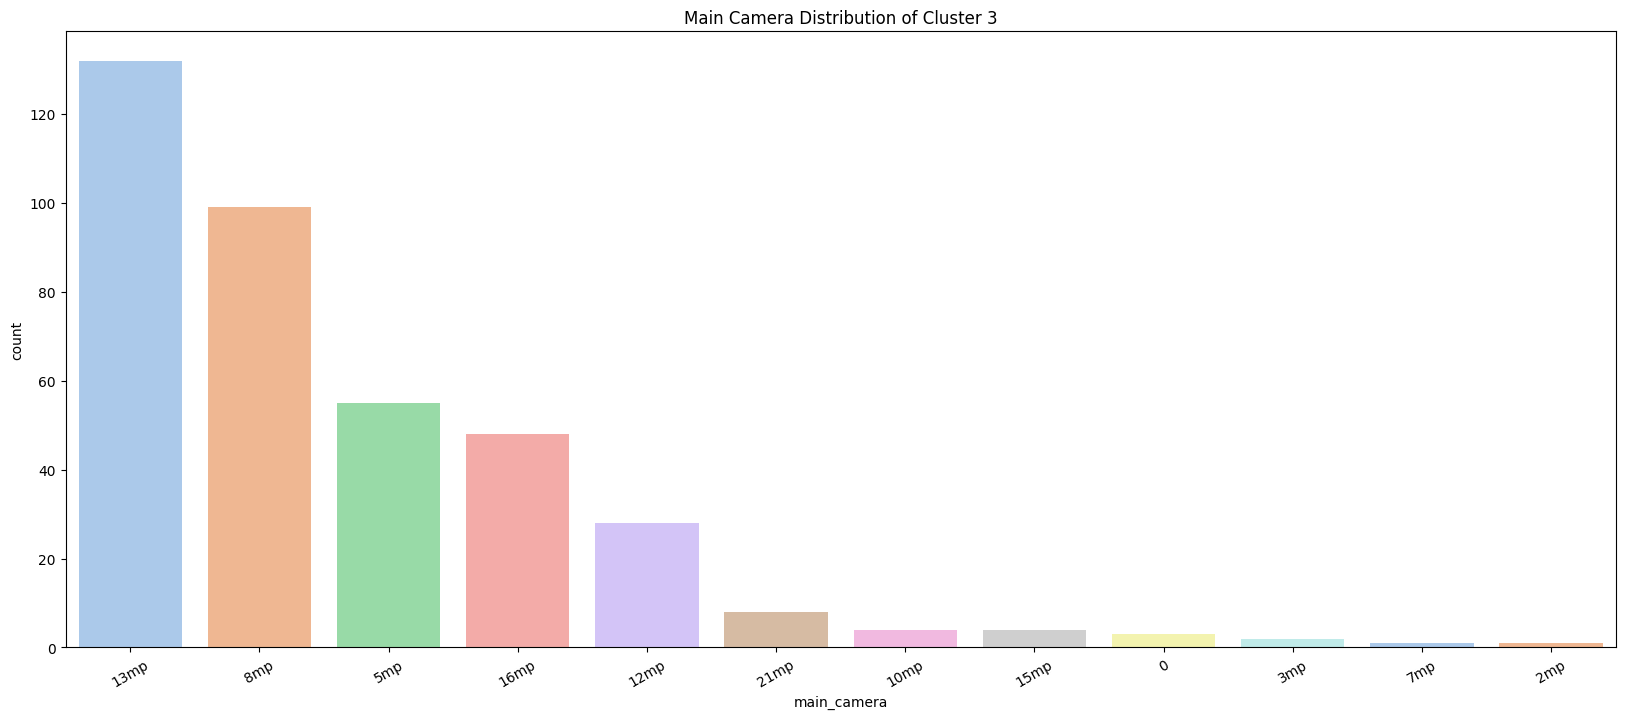

In [67]:
plt.figure(figsize=(20, 8))
sns.barplot(dfc3['main_camera'].value_counts(), palette='pastel')
plt.title("Main Camera Distribution of Cluster 3")
plt.xticks(rotation=30)
plt.show()

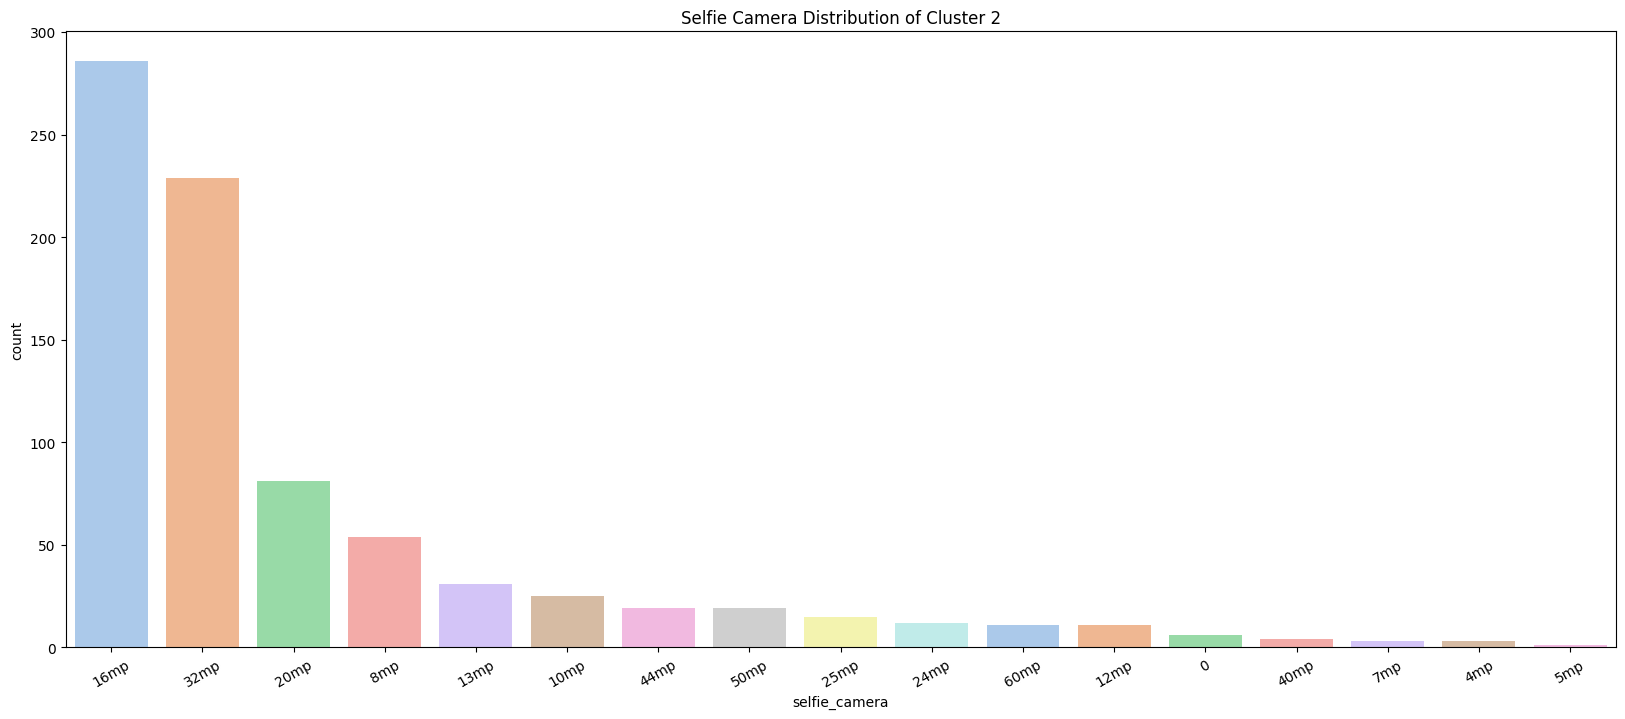

In [68]:
plt.figure(figsize=(20, 8))
sns.barplot(dfc2['selfie_camera'].value_counts(), palette='pastel')
plt.title("Selfie Camera Distribution of Cluster 2")
plt.xticks(rotation=30)
plt.show()

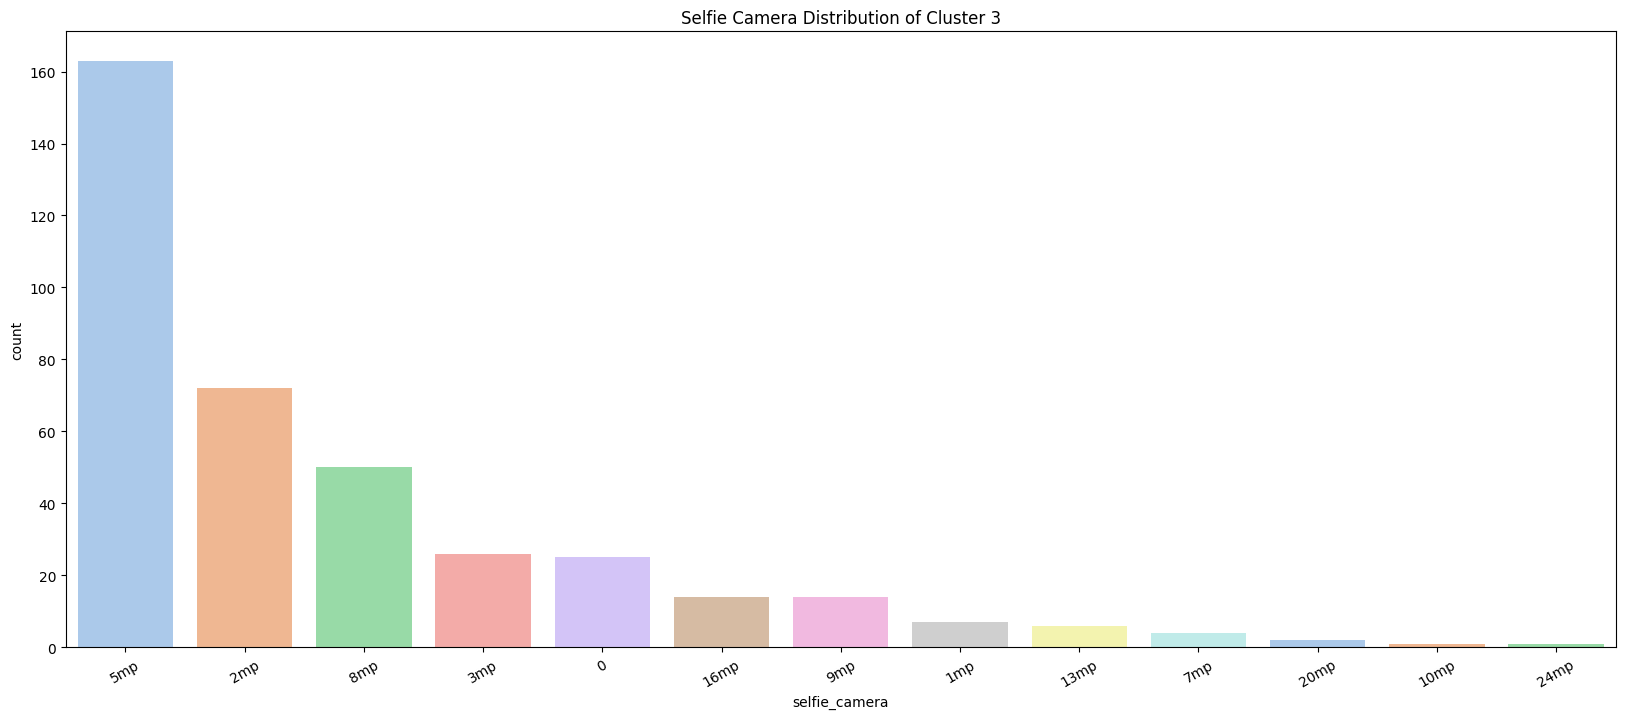

In [69]:
plt.figure(figsize=(20, 8))
sns.barplot(dfc3['selfie_camera'].value_counts(), palette='pastel')
plt.title("Selfie Camera Distribution of Cluster 3")
plt.xticks(rotation=30)
plt.show()

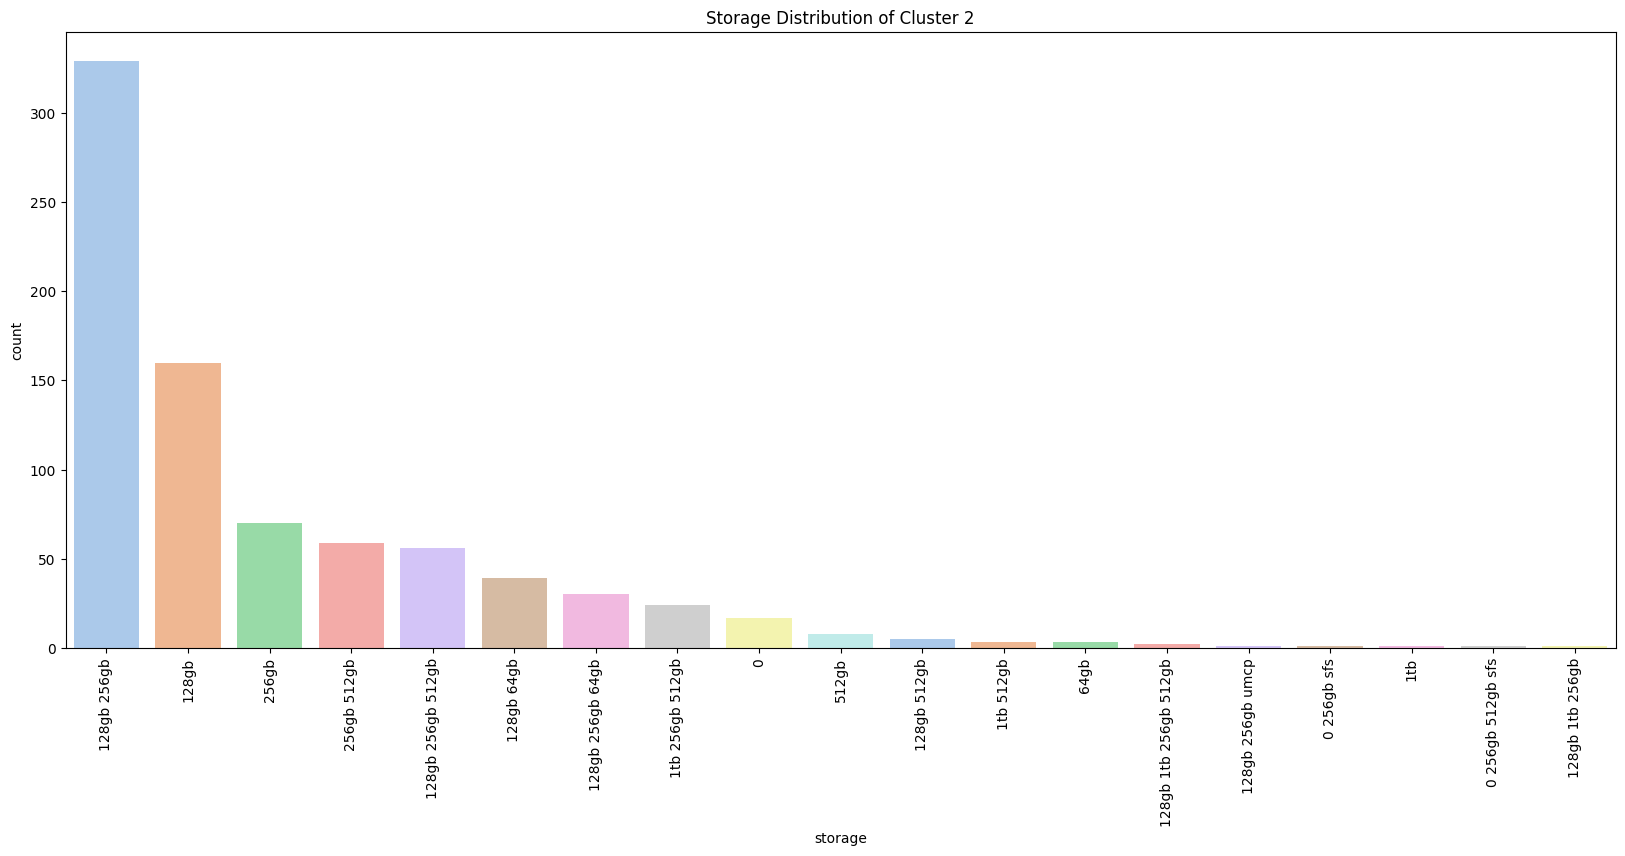

In [70]:
plt.figure(figsize=(20, 8))
sns.barplot(dfc2['storage'].value_counts(), palette='pastel')
plt.title("Storage Distribution of Cluster 2")
plt.xticks(rotation=90)
plt.show()

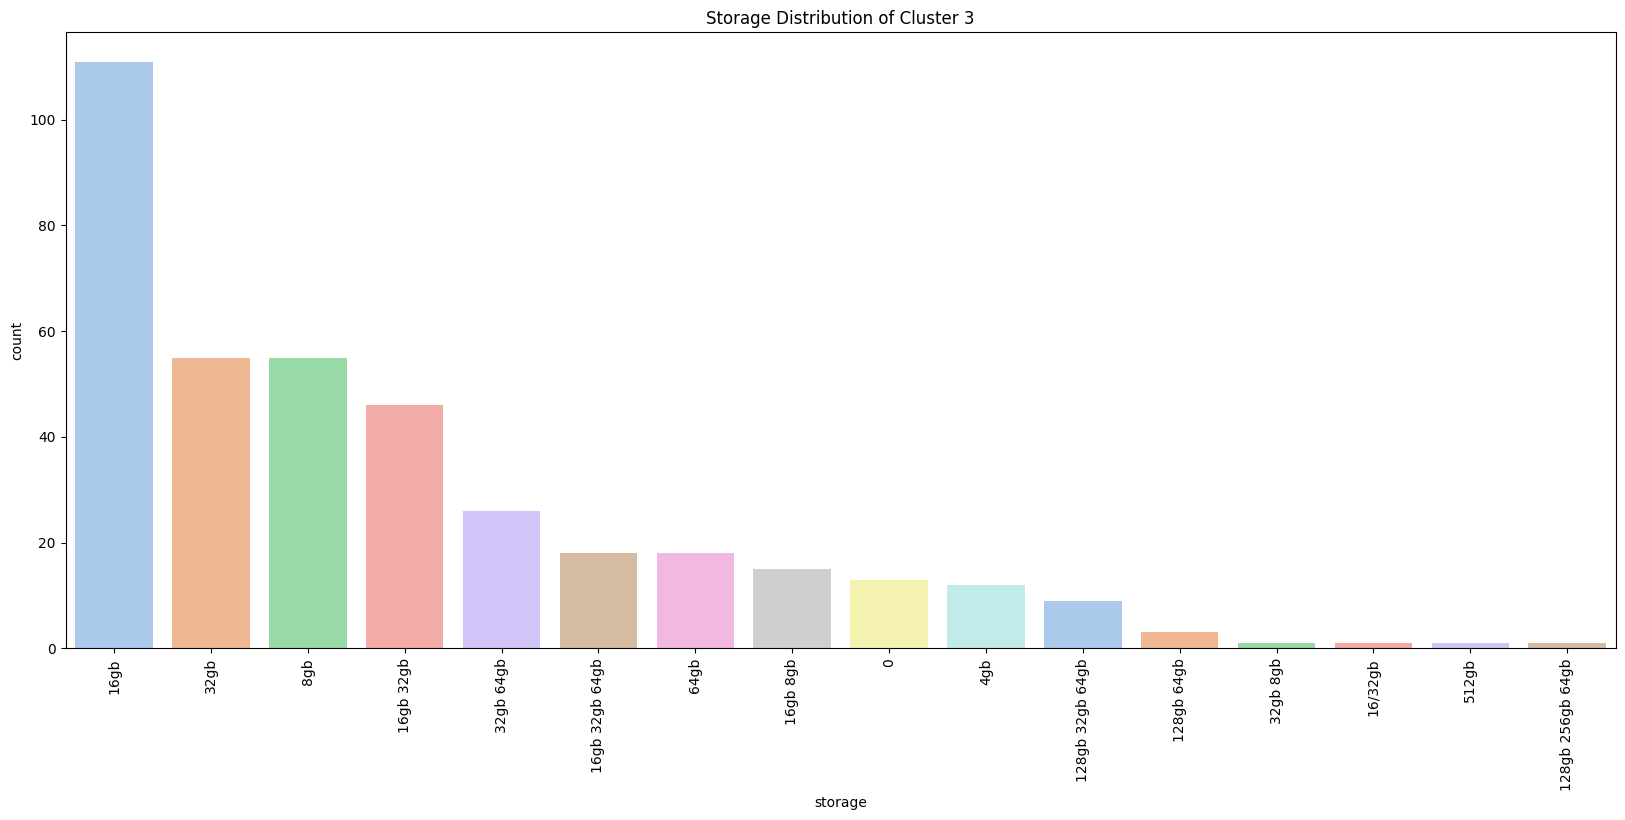

In [71]:
plt.figure(figsize=(20, 8))
sns.barplot(dfc3['storage'].value_counts(), palette='pastel')
plt.title("Storage Distribution of Cluster 3")
plt.xticks(rotation=90)
plt.show()

### Finish
